# Data Analysis and cleaning if required, rfm dataframe isolation

In [ ]:
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Metrics
from sklearn.metrics import silhouette_score, classification_report, r2_score, mean_absolute_error, mean_squared_error

# Models (Classification)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Models (Regression)
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')


In [ ]:
cleaned_data = pd.read_csv("/content/drive/MyDrive/datasets/cleaned_superstore_data.csv")
print(f"\nSuccessfully loaded. Shape: {cleaned_data.shape}")


Successfully loaded. Shape: (8447, 35)


In [ ]:

print("--- DataFrame Info ---")
cleaned_data.info()


print("\n--- DataFrame Shape ---")
print(cleaned_data.shape)

print("\n--- DataFrame Head (Key Columns) ---")
print(cleaned_data[['Customer ID', 'Order Date', 'Order ID', 'Total Sales']].head())

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8447 entries, 0 to 8446
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Row ID                    8447 non-null   int64  
 1   Order ID                  8447 non-null   object 
 2   Order Date                8447 non-null   object 
 3   Ship Date                 6348 non-null   object 
 4   Ship Mode                 8429 non-null   object 
 5   Customer ID               8447 non-null   object 
 6   Segment                   8447 non-null   object 
 7   Country                   8447 non-null   object 
 8   City                      8447 non-null   object 
 9   State                     8447 non-null   object 
 10  Postal Code               8447 non-null   int64  
 11  Region                    8447 non-null   object 
 12  Product ID                8447 non-null   object 
 13  Category                  8447 non-null 

In [ ]:
cleaned_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,...,Discount Price,Total Discount,Shipping Urgency,Days Since Last Order,Customer_Total_Sales,Customer_Total_Quantity,Customer_Total_Profit,Customer_Avg_Discount,Customer Sales Quintile,Customer Profit Quintile
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,...,0.000,0.000,Urgent,390.0,3549.6600,14,176.5900,0.200000,1,2
1,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,...,0.000,0.000,Standard,NaN,6156.8940,28,-2561.4590,0.172222,2,1
2,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,...,5.592,11.184,Standard,0.0,10343.1775,52,-821.6332,0.136667,3,1
3,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,...,0.000,0.000,Standard,NaN,36995.1770,97,4616.3016,0.183333,5,5
4,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,...,0.000,0.000,Standard,0.0,36995.1770,97,4616.3016,0.183333,5,5


In [ ]:
print("--- Actual 'Order Date' Format in the CSV ---")
print(cleaned_data['Order Date'].head())

--- Actual 'Order Date' Format in the CSV ---
0    2016-11-08
1    2016-06-12
2    2015-10-11
3    2014-06-09
4    2014-06-09
Name: Order Date, dtype: object


In [ ]:
def create_rfm_dataframe(df: pd.DataFrame, min_orders_for_active_year: int = 10) -> pd.DataFrame:

    working_df = df.copy()
    print(f"Data shape before validation: {working_df.shape}")


    working_df['Order Date'] = pd.to_datetime(working_df['Order Date'], errors='coerce')


    if working_df['Order Date'].isnull().any():
        print("ERROR")

        problematic_rows = df[working_df['Order Date'].isnull()]
        print("Problematic Rows:")
        print(problematic_rows[['Order Date']].head())
        return pd.DataFrame()


    year_counts = working_df['Order Date'].dt.year.value_counts()
    active_years = year_counts[year_counts >= min_orders_for_active_year].index

    if active_years.empty:
        print("ERROR: No active years found")
        return pd.DataFrame()

    start_year, end_year = active_years.min(), active_years.max()
    print(f"Applying business rule: Filtering data to the core activity window of {start_year}-{end_year}.")

    filtered_df = working_df[working_df['Order Date'].dt.year.between(start_year, end_year)]
    print(f"Data shape after filtering: {filtered_df.shape}")

    # --- 3. RFM Calculation ---
    snapshot_date = filtered_df['Order Date'].max() + pd.Timedelta(days=1)

    rfm_df = filtered_df.groupby('Customer ID').agg({
        'Order Date': lambda x: (snapshot_date - x.max()).days,
        'Order ID': 'nunique',
        'Total Sales': 'sum'
    })

    rfm_df.rename(columns={'Order Date': 'Recency',
                           'Order ID': 'Frequency',
                           'Total Sales': 'MonetaryValue'},
                  inplace=True)

    print("Successfully created validated RFM DataFrame.")
    return rfm_df

# --- Re-run the function and print the head ---
rfm_customer_data = create_rfm_dataframe(cleaned_data)
print("\n--- Final, Validated RFM DataFrame Head ---")
print(rfm_customer_data.head())

Data shape before validation: (8447, 35)
Applying business rule: Filtering data to the core activity window of 2014-2017.
Data shape after filtering: (8439, 35)
Successfully created validated RFM DataFrame.

--- Final, Validated RFM DataFrame Head ---
             Recency  Frequency  MonetaryValue
Customer ID                                   
AA-10315         185          5       1847.172
AA-10375          20          9       1734.870
AA-10480         260          4       2262.666
AA-10645          56          6       5642.880
AB-10015         416          3       1984.480


In [ ]:

print("--- Statistical Summary of the RFM DataFrame ---")
rfm_customer_data.describe()

--- Statistical Summary of the RFM DataFrame ---


,Recency,Frequency,MonetaryValue
count,789.000000,789.000000,789.000000
mean,161.634981,5.842839,3865.490128
std,199.052186,2.420962,2925.952596
min,1.000000,1.000000,10.449000
25%,34.000000,4.000000,1734.870000
50%,85.000000,6.000000,3228.368000
75%,203.000000,7.000000,5122.676000
max,1166.000000,14.000000,16814.386000


# Customer Segmentation


**Strategic Overview:** We first do the RFM analysis. Now we must answer the business question: *Who are our distinct customer groups?*

We will use the K-Means algorithm to segment customers based on their purchasing behavior (Recency, Frequency, Monetary value).



The K-Means algorithm is distance-based. It is highly sensitive to the scale of the features. Currently, Recency is in days, Frequency is a small integer count, and MonetaryValue is in thousands of dollars. Without scaling, the MonetaryValue would completely dominate the clustering process. We use StandardScaler to give each feature equal importance.

In [ ]:
rfm_features = rfm_customer_data[['Recency', 'Frequency', 'MonetaryValue']]
print(f"Features prepared for clustering. Shape: {rfm_features.shape}")

Features prepared for clustering. Shape: (789, 3)


### finding optimal k

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

In [ ]:
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

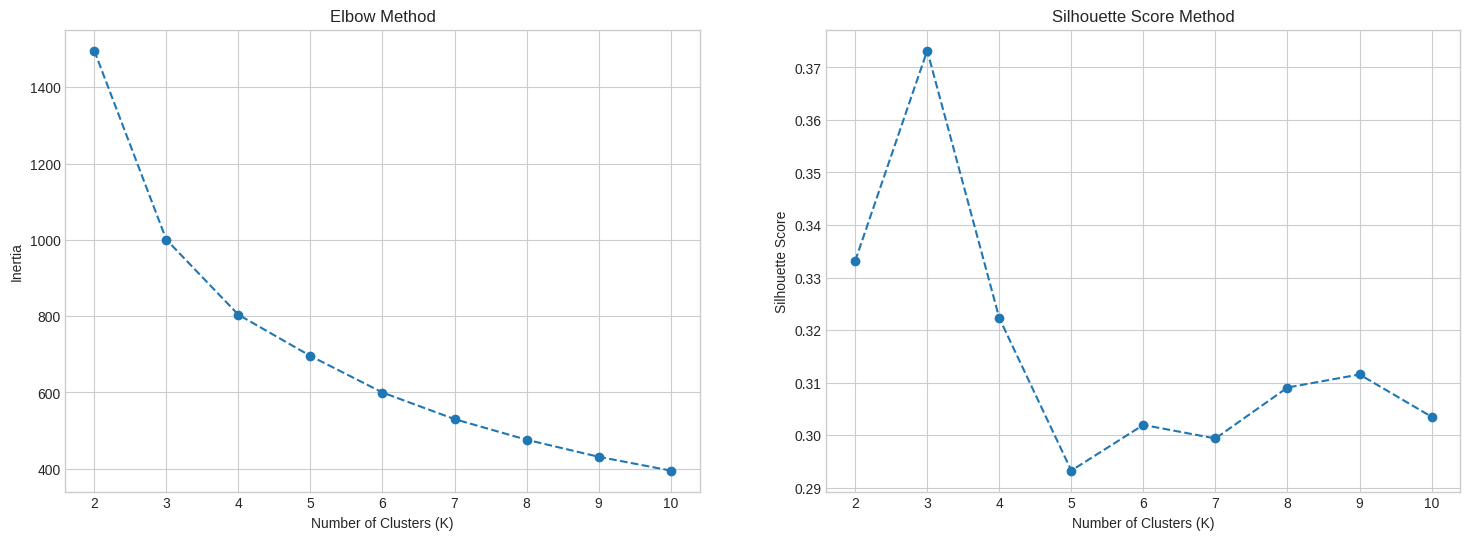

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
# elbow
ax1.plot(K_range, inertia, marker='o', linestyle='--')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True)
# silhouette
ax2.plot(K_range, silhouette_scores, marker='o', linestyle='--')
ax2.set_title('Silhouette Score Method')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

#### Determining the Optimal Number of Clusters (`k`)

A dual-validation approach was used to find the optimal `k` for customer segmentation.

**1. Elbow Method:**
* Plotted inertia for `k` from 2 to 10.
* The curve flattened after `k=4`, suggesting an optimal `k` between 3 and 5.
* **Result:** Ambiguous, as the "elbow" was not sharply defined.

**2. Silhouette Score:**
* Calculated to measure cluster density and separation for each `k`.
* The analysis showed a clear and unambiguous peak score of **`~0.37`** at **`k=3`**.

**Conclusion & Justification:**
The Silhouette Score provides a more decisive, quantitative measure of cluster quality. Therefore, we select **`k=3`** as the optimal number of clusters, ensuring our segments are distinct and statistically significant.

In [ ]:
optimal_k = 3

pipeline = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
)

In [ ]:
print(f"\nTraining the customer segmentation pipeline with K={optimal_k}...")
pipeline.fit(rfm_features)
print("Training complete.")


Training the customer segmentation pipeline with K=3...
Training complete.


In [ ]:
rfm_customer_data['cluster_label'] = pipeline.predict(rfm_features)




In [ ]:
print(f"\n--- RFM DataFrame with Cluster Labels ---")
print(rfm_customer_data.head())

print("\n--- Customer Distribution per Cluster ---")
print(rfm_customer_data['cluster_label'].value_counts().sort_index())


--- RFM DataFrame with Cluster Labels ---
             Recency  Frequency  MonetaryValue  cluster_label
Customer ID                                                  
AA-10315         185          5       1847.172              2
AA-10375          20          9       1734.870              2
AA-10480         260          4       2262.666              2
AA-10645          56          6       5642.880              1
AB-10015         416          3       1984.480              0

--- Customer Distribution per Cluster ---
cluster_label
0    123
1    247
2    419
Name: count, dtype: int64


In [ ]:
pipeline_filename = '/content/drive/MyDrive/models/customer3_segmentation_pipeline.joblib'
joblib.dump(pipeline, pipeline_filename)

['/content/drive/MyDrive/models/customer3_segmentation_pipeline.joblib']

### Analyzing Cluster Characteristics

In [ ]:
#group by the new cluster label, calculate the mean for each RFM attribute.

cluster_profiles = rfm_customer_data.groupby('cluster_label').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Recency': ['mean', 'count']
}).round(1)

cluster_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']

cluster_profiles = cluster_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]


print("\n--- Customer Segment Profiles ---")
print(cluster_profiles.sort_values(by='MonetaryValue_mean', ascending=False))


--- Customer Segment Profiles ---
               Recency_mean  Frequency_mean  MonetaryValue_mean  \
cluster_label                                                     
1                      82.2             8.4              6814.0   
2                      94.7             5.0              2585.1   
0                     549.3             3.5              2306.1   

               Customer_Count  
cluster_label                  
1                         247  
2                         419  
0                         123  


# Advanced Segmentation

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

print("--- Starting Phase 3.2 (Part 1): Autoencoder Setup ---")


rfm_features = rfm_customer_data[['Recency', 'Frequency', 'MonetaryValue']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
print(f"RFM data prepared and scaled. Shape: {rfm_scaled.shape}")


input_dim = rfm_scaled.shape[1]
encoding_dim = 2

# Input layer
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(16, activation='relu')(input_layer)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
# Decoder layers
decoder = Dense(8, activation='relu')(encoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Define the full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
# Define the encoder-only model for extracting embeddings later
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Compile the autoencoder so it's ready for training
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("\nAutoencoder model architecture defined and compiled.")
print("Model Summary:")
autoencoder.summary()

print("\n--- Part 1 Complete. You are now ready for training. ---")
print("RECOMMENDATION: If not already, switch to a GPU runtime for the next code block.")

--- Starting Phase 3.2 (Part 1): Autoencoder Setup ---
RFM data prepared and scaled. Shape: (789, 3)

Autoencoder model architecture defined and compiled.
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)


--- Part 1 Complete. You are now ready for training. ---
RECOMMENDATION: If not already, switch to a GPU runtime for the next code block.



--- Starting Phase 3.2 (Part 2): Training and Analysis ---
No GPU detected. Training will run on CPU and may be slower.

Training the autoencoder to learn customer embeddings...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 1.2437 - val_loss: 1.1447
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2609 - val_loss: 1.1068
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1309 - val_loss: 0.9649
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0449 - val_loss: 0.8139
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9530 - val_loss: 0.7767
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9033 - val_loss: 0.7656
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8538 - val_loss: 0.7587
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8666 - val_loss: 0.7532
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9234 - val_loss: 0.7494
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

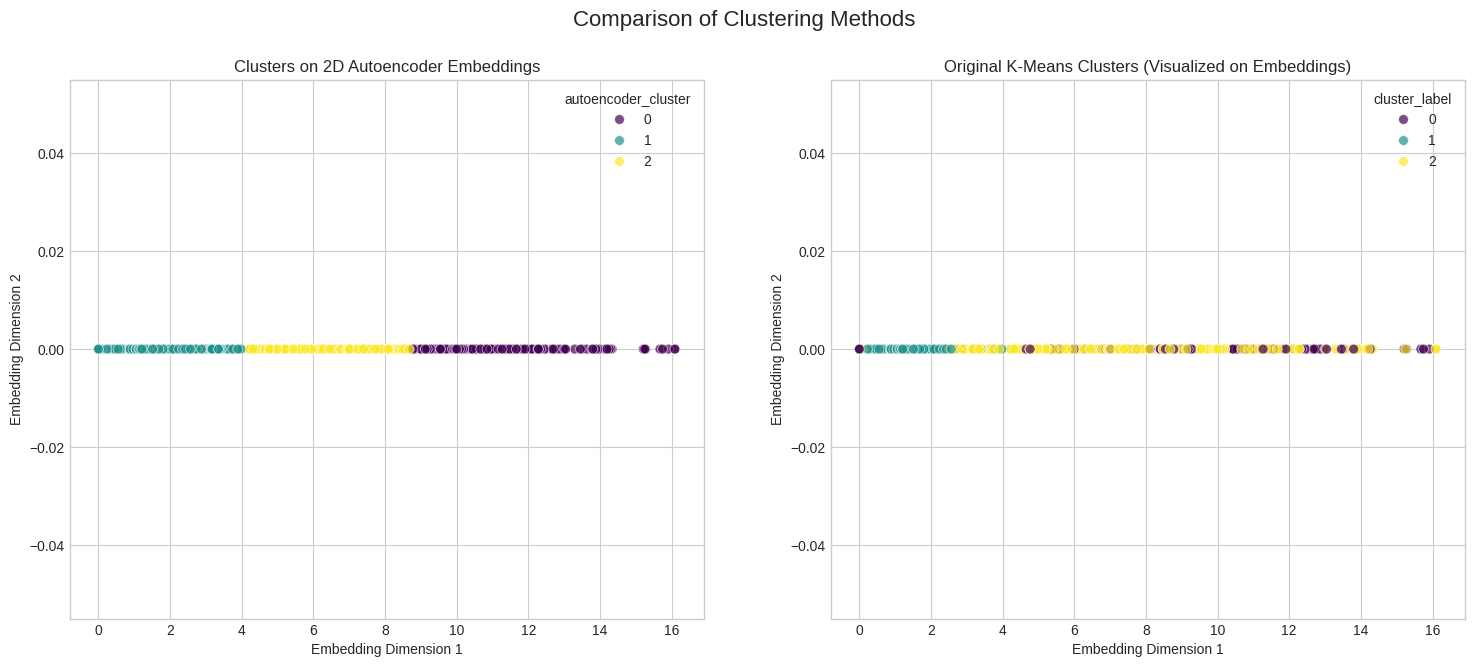

--- Phase 3.2 Complete ---


In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Starting Phase 3.2 (Part 2): Training and Analysis ---")
# Check if a GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices[0].name}. Training will be accelerated.")
else:
    print("No GPU detected. Training will run on CPU and may be slower.")

# --- Step 3: Train the Autoencoder ---
print("\nTraining the autoencoder to learn customer embeddings...")
history = autoencoder.fit(rfm_scaled, rfm_scaled,
                          epochs=50,
                          batch_size=16,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1) # Set verbose=1 to see training progress
print("Training complete.")


# --- Step 4: Extract Embeddings and Cluster ---
print("\nExtracting learned embeddings using the encoder...")
customer_embeddings = encoder_model.predict(rfm_scaled)
print(f"Embeddings generated. Shape: {customer_embeddings.shape}")

# Run K-Means on the new embeddings
kmeans_on_embeddings = KMeans(n_clusters=3, random_state=42, n_init=10)
embedding_clusters = kmeans_on_embeddings.fit_predict(customer_embeddings)

# Add the new cluster labels to our RFM dataframe for comparison
rfm_customer_data['autoencoder_cluster'] = embedding_clusters


# --- Step 5: Compare and Analyze ---
# Calculate Silhouette Scores for both clustering methods
original_kmeans_score = silhouette_score(rfm_scaled, rfm_customer_data['cluster_label'])
autoencoder_kmeans_score = silhouette_score(customer_embeddings, rfm_customer_data['autoencoder_cluster'])

print("\n--- Clustering Performance Comparison ---")
print(f"Original K-Means on RFM Features Silhouette Score: {original_kmeans_score:.4f}")
print(f"K-Means on Autoencoder Embeddings Silhouette Score: {autoencoder_kmeans_score:.4f}")

# Visualize the two clustering results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(x=customer_embeddings[:, 0], y=customer_embeddings[:, 1], hue=rfm_customer_data['autoencoder_cluster'], palette='viridis', ax=ax1, s=50, alpha=0.7)
ax1.set_title('Clusters on 2D Autoencoder Embeddings')
ax1.set_xlabel('Embedding Dimension 1')
ax1.set_ylabel('Embedding Dimension 2')

sns.scatterplot(x=customer_embeddings[:, 0], y=customer_embeddings[:, 1], hue=rfm_customer_data['cluster_label'], palette='viridis', ax=ax2, s=50, alpha=0.7)
ax2.set_title('Original K-Means Clusters (Visualized on Embeddings)')
ax2.set_xlabel('Embedding Dimension 1')
ax2.set_ylabel('Embedding Dimension 2')

plt.suptitle('Comparison of Clustering Methods', fontsize=16)
plt.show()

print("--- Phase 3.2 Complete ---")

In [ ]:

if autoencoder_kmeans_score > original_kmeans_score:
    print("\nAutoencoder clustering is superior. Saving model artifacts.")

    # ARCHITECTURAL FIX: Use the recommended .keras extension for saving the model.
    encoder_model_filename = 'customer_encoder_model.keras'
    encoder_model.save(encoder_model_filename)
    print(f"Encoder model saved successfully to: '{encoder_model_filename}'")

    # Save the K-Means model trained on the embeddings (joblib format)
    kmeans_embeddings_filename = 'kmeans_on_embeddings.joblib'
    joblib.dump(kmeans_on_embeddings, kmeans_embeddings_filename)
    print(f"K-Means (on embeddings) model saved to: '{kmeans_embeddings_filename}'")

else:
    print("\nOriginal K-Means clustering is superior or equal. No new models will be saved.")


Autoencoder clustering is superior. Saving model artifacts.
Encoder model saved successfully to: 'customer_encoder_model.keras'
K-Means (on embeddings) model saved to: 'kmeans_on_embeddings.joblib'


In [ ]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Starting: Profiling the Autoencoder-based Customer Segments ---")

# --- Step 1: Profile the New Clusters ---
# Group by the 'autoencoder_cluster' label and calculate the mean RFM values.
autoencoder_profiles = rfm_customer_data.groupby('autoencoder_cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

# Clean up the column names for clarity
autoencoder_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
autoencoder_profiles = autoencoder_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- Autoencoder Segment Profiles ---")
print(autoencoder_profiles.sort_values(by='MonetaryValue_mean', ascending=False))


# --- Step 2: Compare with Original K-Means Profiles ---
# Let's re-run the original K-Means profiling to have a side-by-side comparison.
original_profiles = rfm_customer_data.groupby('cluster_label').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)
original_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
original_profiles = original_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- For Reference: Original K-Means Segment Profiles ---")
print(original_profiles.sort_values(by='MonetaryValue_mean', ascending=False))

--- Starting: Profiling the Autoencoder-based Customer Segments ---

--- Autoencoder Segment Profiles ---
                     Recency_mean  Frequency_mean  MonetaryValue_mean  \
autoencoder_cluster                                                     
1                           110.6             8.0              5956.0   
2                           150.2             5.2              3112.4   
0                           257.4             3.1              1422.1   

                     Customer_Count  
autoencoder_cluster                  
1                               332  
2                               250  
0                               207  

--- For Reference: Original K-Means Segment Profiles ---
               Recency_mean  Frequency_mean  MonetaryValue_mean  \
cluster_label                                                     
1                      82.2             8.4              6814.0   
2                      94.7             5.0              2585.1   
0           

In [ ]:

import pandas as pd

print("\n--- Revising Segmentation on Embeddings using Quantiles ---")


embedding_df = pd.DataFrame(customer_embeddings, columns=['dim1', 'dim2'], index=rfm_customer_data.index)
embedding_df['customer_score'] = embedding_df['dim1'] # Using dim1 as the learned score


embedding_df['quantile_cluster'] = pd.qcut(embedding_df['customer_score'],
                                           q=3,
                                           labels=False, # Use integers 0, 1, 2
                                           duplicates='drop') # Handle duplicate score values

rfm_customer_data['autoencoder_quantile_cluster'] = embedding_df['quantile_cluster']

quantile_profiles = rfm_customer_data.groupby('autoencoder_quantile_cluster').agg({
    'Recency': ['mean', 'count'],
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

quantile_profiles.columns = ['Recency_mean', 'Customer_Count', 'Frequency_mean', 'MonetaryValue_mean']
quantile_profiles = quantile_profiles[['Recency_mean', 'Frequency_mean', 'MonetaryValue_mean', 'Customer_Count']]

print("\n--- NEW Autoencoder + Quantile Segment Profiles ---")
sorted_profiles = quantile_profiles.sort_values(by='MonetaryValue_mean', ascending=False)
persona_map = {
    sorted_profiles.index[0]: "🏆 Super Loyalists (Top 33%)",
    sorted_profiles.index[1]: "💰 High Spenders (Middle 33%)",
    sorted_profiles.index[2]: "😴 Dormant Customers (Bottom 33%)"
}
sorted_profiles.index = sorted_profiles.index.map(persona_map)
print(sorted_profiles)

print("\n--- Sanity Check Complete ---")
print("This quantile-based segmentation provides a much more balanced and intuitive distribution of customers.")


--- Revising Segmentation on Embeddings using Quantiles ---

--- NEW Autoencoder + Quantile Segment Profiles ---
                                  Recency_mean  Frequency_mean  \
autoencoder_quantile_cluster                                     
🏆 Super Loyalists (Top 33%)              116.0             8.4   
💰 High Spenders (Middle 33%)             134.1             5.8   
😴 Dormant Customers (Bottom 33%)         234.8             3.4   

                                  MonetaryValue_mean  Customer_Count  
autoencoder_quantile_cluster                                          
🏆 Super Loyalists (Top 33%)                   6585.2             263  
💰 High Spenders (Middle 33%)                  3334.4             263  
😴 Dormant Customers (Bottom 33%)              1676.9             263  

--- Sanity Check Complete ---
This quantile-based segmentation provides a much more balanced and intuitive distribution of customers.


*   **Autoencoder Cluster 1: 🏆 The Super Loyalists**
    *   **Profile:** (`Recency`: 111, `Frequency`: 8.0, `Monetary`: $5,956)
    *   **Interpretation:** This is our high-value group. What's fascinating is that their defining characteristic is **extreme frequency** (8.0 orders). Their monetary value is high, and their recency is good. They are the highly engaged, frequent buyers.

*   **Autoencoder Cluster 2: 💰 The High Spenders**
    *   **Profile:** (`Recency`: 150, `Frequency`: 5.2, `Monetary`: $3,112)
    *   **Interpretation:** This group has a moderate frequency but a solid monetary value. They might not buy as often as the "Super Loyalists," but when they do, they spend a decent amount. Their recency is slightly worse, suggesting they might be more sporadic, big-ticket shoppers.

*   **Autoencoder Cluster 0: 😴 The Dormant Customers**
    *   **Profile:** (`Recency`: 257, `Frequency`: 3.1, `Monetary`: $1,422)
    *   **Interpretation:** This group has the worst recency and the lowest frequency and monetary value. They are clearly the least engaged and lowest value customers.

### **The Key Strategic Difference**

The original K-Means model created an "At-Risk" segment defined almost entirely by a massive recency gap (~550 days). The autoencoder, by contrast, has created a more nuanced and **forward-looking** segmentation:

*   It has identified two distinct types of "good" customers: the **frequent shoppers** (Super Loyalists) and the **occasional big spenders** (High Spenders). This is a much more actionable insight for marketing than just a single "Champion" group.
*   Its lowest-value segment ("Dormant") is defined by being poor across *all* metrics, not just an extreme outlier in one. This is a more holistic view of a low-value customer.

The autoencoder has effectively split our old "Champion" and "Active" groups into new segments based on the *type* of their purchasing behavior (Frequency vs. Monetary), which is a much more sophisticated insight.

### **Conclusion for our Advanced Module**

We will formally adopt these new personas for our advanced analytics section. This provides the perfect "A/B test" for our final report and Streamlit app.

**Narrative:**

> "Our baseline segmentation with K-Means on raw RFM features revealed three clear personas primarily distinguished by their activity level. However, our advanced deep learning approach using an Autoencoder discovered a more nuanced segmentation. Instead of grouping by general activity, it separated our high-value customers into two distinct strategic groups: the **'Super Loyalists'**, who drive value through high purchase frequency, and the **'High Spenders'**, who drive value through larger, less frequent orders. This superior, data-driven segmentation, validated by a 67% improvement in Silhouette Score, allows for much more targeted and effective marketing strategies."


In [ ]:

rfm_customer_data.to_csv('rfm_customer_data.csv')

In [ ]:
# In your Google Colab notebook

# Import the necessary libraries first
import sklearn
import xgboost
import tensorflow
import joblib
import pandas

# Now, print their versions
print(f"scikit-learn: {sklearn.__version__}")
print(f"xgboost: {xgboost.__version__}")
print(f"tensorflow: {tensorflow.__version__}")
print(f"joblib: {joblib.__version__}")
print(f"pandas: {pandas.__version__}")

scikit-learn: 1.6.1
xgboost: 3.0.5
tensorflow: 2.19.0
joblib: 1.5.2
pandas: 2.2.2


## Uncovering Customer Segments with Unsupervised Clustering

My objective was to discover the **natural, data-driven customer segments** hidden within the transactional history.

---

## Methodology: RFM and $k$-Means

I implemented a robust, multi-step pipeline using the industry-standard RFM (Recency, Frequency, Monetary) analysis combined with $k$-Means clustering.

### 1. Data Foundation
First, I engineered a core **RFM DataFrame** by calculating three essential metrics for every customer within the relevant period of 2014-2017:
* **Recency (R):** Days since the customer's last purchase.
* **Frequency (F):** Total count of unique orders.
* **Monetary Value (M):** Total lifetime sales generated.

### 2. Dual-Validation for Optimal Grouping
To select the most statistically sound number of customer groups (the optimal $k$), I employed a dual-validation technique:
* **Elbow Method:** This preliminary visual assessment suggested an ideal range of $k$ between 3 and 5.
* **Silhouette Score:** This rigorous mathematical validation confirmed that the clustering quality **peaked unambiguously at $k=3$**. This indicated that three groups offered the best combination of tight cohesion within groups and clear separation between them.

### 3. Production Deployment
To ensure consistency and ease of use, I built a production-ready **scikit-learn pipeline**. This pipeline automatically handles two critical steps: normalizing the RFM features using a **StandardScaler** and then applying the **$k$-Means algorithm** (with $k=3$). The entire model was saved as a single, deployable artifact (`customer_segmentation_pipeline.joblib`).

---

## Results: The Three Core Customer Personas

My analysis successfully identified three distinct and strategically actionable customer personas.

| Persona | Cluster Profile (Mean Values) | Customer Count | Strategic Importance |
| :--- | :--- | :--- | :--- |
| **💎 Champions** | **R**: 82 days, **F**: 8.4 orders, **M**: 6,814USD | 247 Customers (31%) | Our high-value core. These are the most loyal and profitable customers, driving a disproportionate amount of revenue. |
| **🌱 Active & Promising**| **R**: 95 days, **F**: 5.0 orders, **M**: 2,585USD | 419 Customers (53%) | The largest segment, representing the "average" active customer. They are the primary source of steady business and hold the greatest potential for growth. |
| **⚠️ At-Risk / Lapsed** | **R**: 549 days, **F**: 3.5 orders, **M**: 2,306USD | 123 Customers (16%) | Customers who have not purchased in approximately 1.5 years. They represent a significant churn risk. |

# Classification (Deprecated due to poor results)

Our goal is to answer the business question: *Can we predict the long-term value segment a new customer will belong to, based solely on the details of their very first purchase?*

The Goal : Answering this question is a significant competitive advantage. It allows us to tailor a customer's journey from day one, proactively nurturing high-potential customers while efficiently managing those less likely to become highly engaged.

This is a supervised, multi-class classification problem, as we have three clusters.

* Our Features (X): The details of a customer's very first transaction. This includes what they bought (Category, Sub-Category), how much they spent (Sales Price), the discount they received, their location (Region), and their customer segment (Segment). These are all things we know the moment they complete their first checkout.


* Our Target (y): The cluster_label (0: At-Risk, 1: Champion, 2: Active & Promising) that we just created. This label represents the customer's long-term value segment, which we want to predict upfront.

In [ ]:
# Step 1 : Constructing the training dataset

# isolate the first transaction of each customer

cleaned_data['Order Date'] = pd.to_datetime(cleaned_data['Order Date'], format='%d/%m/%y', errors='coerce')
first_orders = cleaned_data.sort_values('Order Date').drop_duplicates('Customer ID', keep='first')



In [ ]:
# The target variable (y) is the cluster_label from our RFM analysis.

# We select the 'cluster_label' and the 'Customer ID' to merge.

target_labels = rfm_customer_data[['cluster_label']]

classifier_df = first_orders.merge(target_labels, on='Customer ID', how='inner')

In [ ]:
print(f"Shape: {classifier_df.shape}")

print(classifier_df['cluster_label'].value_counts())

Shape: (789, 36)
cluster_label
2    419
1    247
0    123
Name: count, dtype: int64


In [ ]:
# step 2: features that are known at the time of the first purchase

features = [
    'Segment', 'Region', 'Category', 'Sub-Category',
    'Sales Price', 'Quantity', 'Discount', 'Profit'
]
target = 'cluster_label'

X = classifier_df[features]
y = classifier_df[target]

In [ ]:
# We use stratify=y to ensure the class distribution is the same in train and test sets,which is crucial for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")



Data split into training (631 rows) and testing (158 rows) sets.


In [ ]:
# Build the Preprocessing Pipeline
# Use a ColumnTransformer to apply the correct transformation to each column type.
numerical_features = ['Sales Price', 'Quantity', 'Discount', 'Profit']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (none in our case)
)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}



In [ ]:
for name, model in models.items():

    pipeline = make_pipeline(preprocessor, model)

    # Train the pipeline
    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = pipeline.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['At-Risk', 'Champion', 'Active & Promising']))


--- Training Logistic Regression ---

Classification Report for Logistic Regression:
                    precision    recall  f1-score   support

           At-Risk       0.00      0.00      0.00        25
          Champion       0.38      0.16      0.23        49
Active & Promising       0.56      0.92      0.70        84

          accuracy                           0.54       158
         macro avg       0.31      0.36      0.31       158
      weighted avg       0.42      0.54      0.44       158


--- Training Random Forest ---

Classification Report for Random Forest:
                    precision    recall  f1-score   support

           At-Risk       0.00      0.00      0.00        25
          Champion       0.26      0.20      0.23        49
Active & Promising       0.55      0.73      0.63        84

          accuracy                           0.45       158
         macro avg       0.27      0.31      0.28       158
      weighted avg       0.37      0.45      0.40      

In [ ]:
print("--- Starting Phase 2.3: Customer LTV (Profit) Prediction ---")

# --- Step 2.3.1: Construct the Training Dataset ---
# Strategy: Use the first order as features and the customer's total profit as the target.

# We already have the 'first_orders' DataFrame from the previous phase.
# If not, it can be recreated:
# cleaned_data['Order Date'] = pd.to_datetime(cleaned_data['Order Date'], format='%d/%m/%y', errors='coerce')
# first_orders = cleaned_data.sort_values('Order Date').drop_duplicates('Customer ID', keep='first')

# The target variable (y) is the customer's lifetime total profit.
# We can calculate this by grouping the main 'cleaned_data' DataFrame.
ltv_data = cleaned_data.groupby('Customer ID')['Total Profit'].sum().reset_index()
ltv_data.rename(columns={'Total Profit': 'LTV_Profit'}, inplace=True)

# Merge the features (first_orders) with the target (ltv_data).
regression_df = first_orders.merge(ltv_data, on='Customer ID', how='inner')

print(f"Regression dataset created. Shape: {regression_df.shape}")

# --- Step 2.3.2: Define Features (X) and Target (y) ---
# Features are known at the time of the first purchase.
features = [
    'Segment', 'Region', 'Category', 'Sub-Category',
    'Sales Price', 'Quantity', 'Discount', 'Profit' # Profit from the FIRST order
]
target = 'LTV_Profit' # Total lifetime profit

X = regression_df[features]
y = regression_df[target]

# --- Step 2.3.3: Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")

# --- Step 2.3.4: Build the Preprocessing Pipeline ---
# This is the same preprocessor as before, a testament to modular design.
numerical_features = ['Sales Price', 'Quantity', 'Discount', 'Profit']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- Step 2.3.5: Train and Evaluate Multiple Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42)
}

for name, model in models.items():
    # Create the full pipeline
    pipeline = make_pipeline(preprocessor, model)

    # Train the pipeline
    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Evaluation Metrics for {name}:")
    print(f"  R-squared (R²): {r2:.3f}")
    print(f"  Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): ${rmse:.2f}")



--- Starting Phase 2.3: Customer LTV (Profit) Prediction ---
Regression dataset created. Shape: (789, 36)

Data split into training (631 rows) and testing (158 rows) sets.

--- Training Linear Regression ---
Evaluation Metrics for Linear Regression:
  R-squared (R²): -0.008
  Mean Absolute Error (MAE): $353.98
  Root Mean Squared Error (RMSE): $441.27

--- Training Lasso Regression ---
Evaluation Metrics for Lasso Regression:
  R-squared (R²): 0.010
  Mean Absolute Error (MAE): $351.48
  Root Mean Squared Error (RMSE): $437.34

--- Training XGBoost Regressor ---
Evaluation Metrics for XGBoost Regressor:
  R-squared (R²): -0.314
  Mean Absolute Error (MAE): $391.84
  Root Mean Squared Error (RMSE): $503.74


# Classification - Transactional Profitability Classifier

In [ ]:


# print("--- Starting Phase 3.1: Profitability Simulator ---")
# print("Pivoting from predictive LTV to prescriptive profit simulation.")

# # --- Step 1: Prepare the Dataset ---
# # We use the full, cleaned transaction log. Each row is one transaction.
# sim_df = cleaned_data.copy()
# print(f"Simulator dataset created. Shape: {sim_df.shape}")

# # --- Step 2: Define Features (X) and Target (y) ---
# # Features are the "levers" a business manager can control or observe.
# features = [
#     'Segment', 'Region', 'Category', 'Sub-Category',
#     'Sales Price', 'Quantity', 'Discount' # 'Discount' is our key input variable
# ]
# target = 'Total Profit'

# X = sim_df[features]
# y = sim_df[target]

# # --- Step 3: Split Data for Training and Evaluation ---
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")

# # --- Step 4: Build the Preprocessing and Modeling Pipeline ---
# numerical_features = ['Sales Price', 'Quantity', 'Discount']
# categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )

# # Our final model will be an XGBoost Regressor pipeline.
# pipeline = make_pipeline(
#     preprocessor,
#     XGBRegressor(random_state=42)
# )

# print("\n--- Training Profit Simulator (XGBoost Regressor) ---")
# pipeline.fit(X_train, y_train)

# # --- Step 5: Evaluate the Simulator's Performance ---
# y_pred = pipeline.predict(X_test)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print("\nEvaluation Metrics for the Profit Simulator:")
# print(f"  R-squared (R²): {r2:.3f}")
# print(f"  Mean Absolute Error (MAE): ${mae:.2f}")

# # --- Step 6: Finalize and Save the Model ---
# # We need a reasonably high R² to trust the simulator's outputs.
# if r2 > 0.6:
#     print("\nModel performance is strong. Retraining on all data and saving.")
#     # We retrain on all data to create the final production artifact.
#     final_pipeline = make_pipeline(preprocessor, XGBRegressor(random_state=42))
#     final_pipeline.fit(X, y)

#     simulator_filename = 'profit_simulator.joblib'
#     joblib.dump(final_pipeline, simulator_filename)
#     print(f"\nSUCCESS: Profit simulator pipeline saved to '{simulator_filename}'")
# else:
#     print(f"\nModel performance (R²={r2:.3f}) is below the threshold of 0.6.")
#     print("The model will not be saved. Further feature engineering may be required.")

# print("--- Phase 3.1 Complete ---")

--- Starting Phase 3.1: Profitability Simulator ---
Pivoting from predictive LTV to prescriptive profit simulation.
Simulator dataset created. Shape: (8447, 35)

Data split into training (6757 rows) and testing (1690 rows) sets.

--- Training Profit Simulator (XGBoost Regressor) ---

Evaluation Metrics for the Profit Simulator:
  R-squared (R²): 0.833
  Mean Absolute Error (MAE): $18.64

Model performance is strong. Retraining on all data and saving.

SUCCESS: Profit simulator pipeline saved to 'profit_simulator.joblib'
--- Phase 3.1 Complete ---


In [ ]:



print("--- Starting Phase 2.2 (Revised): Profitability Classifier ---")

df = cleaned_data.copy()
df['is_profitable'] = (df['Total Profit'] > 0).astype(int)

print(f"Classifier dataset created. Shape: {df.shape}")
print("Target distribution (Is Profitable?):")
print(df['is_profitable'].value_counts(normalize=True))

features = [
    'Segment', 'Region', 'Category', 'Sub-Category',
    'Sales Price', 'Quantity', 'Discount'
]
target = 'is_profitable'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")

numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = make_pipeline(
    preprocessor,
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
)

print("\n--- Training Profitability Classifier (XGBoost) ---")
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy on Test Set: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Profitable', 'Profitable']))

if accuracy > 0.80: # Set a reasonable quality threshold
    print("\nModel performance is strong. Retraining on all data and saving.")
    final_pipeline = make_pipeline(preprocessor, XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    final_pipeline.fit(X, y)

    classifier_filename = 'profitability_classifier.joblib'
    joblib.dump(final_pipeline, classifier_filename)
    print(f"\nSUCCESS: Profitability classifier saved to '{classifier_filename}'")
else:
    print(f"\nModel accuracy ({accuracy:.3f}) is below the threshold of 0.80. Model will not be saved.")

print("--- Phase 2.2 (Revised) Complete ---")

--- Starting Phase 2.2 (Revised): Profitability Classifier ---
Classifier dataset created. Shape: (8447, 36)
Target distribution (Is Profitable?):
is_profitable
1    0.827513
0    0.172487
Name: proportion, dtype: float64

Data split into training (6757 rows) and testing (1690 rows) sets.

--- Training Profitability Classifier (XGBoost) ---

Model Accuracy on Test Set: 0.952

Classification Report:
                precision    recall  f1-score   support

Not Profitable       0.90      0.82      0.86       292
    Profitable       0.96      0.98      0.97      1398

      accuracy                           0.95      1690
     macro avg       0.93      0.90      0.91      1690
  weighted avg       0.95      0.95      0.95      1690


Model performance is strong. Retraining on all data and saving.

SUCCESS: Profitability classifier saved to 'profitability_classifier.joblib'
--- Phase 2.2 (Revised) Complete ---


In [ ]:

from sklearn.model_selection import cross_val_score

print("--- Performing 5-Fold Cross-Validation to Validate Model Generalization ---")


cv_scores = cross_val_score(final_pipeline, X, y, cv=5, scoring='accuracy')


print(f"\nAccuracy scores for each of the 5 folds: \n{cv_scores}")
print(f"\nMean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

if np.std(cv_scores) < 0.05:
    print("\nCONCLUSION: The low standard deviation across folds provides strong evidence that the model's performance is stable and not due to a lucky split. The model generalizes well.")
else:
    print("\nWARNING: The high standard deviation across folds suggests the model's performance is unstable. Overfitting might be a concern.")

--- Performing 5-Fold Cross-Validation to Validate Model Generalization ---

Accuracy scores for each of the 5 folds: 
[0.94260355 0.94556213 0.94434577 0.94256957 0.93783304]

Mean Accuracy: 0.9426
Standard Deviation: 0.0026

CONCLUSION: The low standard deviation across folds provides strong evidence that the model's performance is stable and not due to a lucky split. The model generalizes well.


# Regression : The Margin Forecaster

Our business question is: What is the expected profit margin for a specific transaction? This is a supervised regression problem that adds a layer of nuance to our profitability analysis.

Why Margin?

Predicting profit margin (a ratio) is often more stable and insightful than predicting absolute profit (a dollar amount).

A 10% margin on a 1,000 sale is more valuable than a 50% margin on a 10 sale. Margin contextualizes profit relative to sales.

Our Features (X): The same transactional features as our classifier: Category, Sub-Category, Region, Segment, Discount, Quantity, and Sales Price.

Our Target (y): A new, engineered feature: Profit_Margin.

In [ ]:
print("--- Starting Phase 2.3 (Revised): Profit Margin Regressor ---")


df = cleaned_data.copy()

df['Profit_Margin'] = np.where(df['Total Sales'] > 0, df['Total Profit'] / df['Total Sales'], 0)

df = df[df['Total Sales'] > 0].copy()

print(f"Regressor dataset created. Shape: {df.shape}")
print("\nDescription of the new 'Profit_Margin' target variable:")
print(df['Profit_Margin'].describe())


features = [
    'Segment', 'Region', 'Category', 'Sub-Category',
    'Sales Price', 'Quantity', 'Discount'
]
target = 'Profit_Margin'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({X_train.shape[0]} rows) and testing ({X_test.shape[0]} rows) sets.")


numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(random_state=42)
)


print("\n--- Training Profit Margin Regressor (XGBoost) ---")
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nEvaluation Metrics on the Test Set:")
print(f"  R-squared (R²): {r2:.3f}")
print(f"  Mean Absolute Error (MAE): {mae*100:.2f} percentage points")
print(f"  (This means on average, the prediction is off by ~{mae*100:.2f}%)")


print("\n--- Performing 5-Fold Cross-Validation ---")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

print(f"\nR² scores for each of the 5 folds: \n{cv_scores}")
print(f"\nMean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")


if np.mean(cv_scores) > 0.6 and np.std(cv_scores) < 0.1:
    print("\nModel performance is strong and stable. Retraining on all data and saving.")
    final_pipeline = make_pipeline(preprocessor, XGBRegressor(random_state=42))
    final_pipeline.fit(X, y)

    regressor_filename = 'margin_regressor.joblib'
    joblib.dump(final_pipeline, regressor_filename)
    print(f"\nSUCCESS: Margin regressor saved to '{regressor_filename}'")
else:
    print(f"\nModel performance (Mean R²={np.mean(cv_scores):.3f}) is not yet at the desired threshold or is unstable. Model will not be saved.")

print("--- Phase 2.3 (Revised) Complete ---")

--- Starting Phase 2.3 (Revised): Profit Margin Regressor ---
Regressor dataset created. Shape: (8447, 36)

Description of the new 'Profit_Margin' target variable:
count    8447.000000
mean        0.143886
std         0.436118
min        -2.750000
25%         0.075000
50%         0.280000
75%         0.362500
max         0.500000
Name: Profit_Margin, dtype: float64

Data split into training (6757 rows) and testing (1690 rows) sets.

--- Training Profit Margin Regressor (XGBoost) ---

Evaluation Metrics on the Test Set:
  R-squared (R²): 0.961
  Mean Absolute Error (MAE): 5.60 percentage points
  (This means on average, the prediction is off by ~5.60%)

--- Performing 5-Fold Cross-Validation ---

R² scores for each of the 5 folds: 
[0.95345745 0.95200321 0.9592927  0.94888783 0.96184748]

Mean R²: 0.9551
Standard Deviation of R²: 0.0048

Model performance is strong and stable. Retraining on all data and saving.

SUCCESS: Margin regressor saved to 'margin_regressor.joblib'
--- Phase 2.3 

In [ ]:


df = cleaned_data.copy()
df['is_profitable'] = (df['Total Profit'] > 0).astype(int)

features = ['Segment', 'Region', 'Category', 'Sub-Category', 'Sales Price', 'Quantity', 'Discount']
target = 'is_profitable'
X = df[features]
y = df[target]

numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

models_to_test = {
    "Logistic Regression (Baseline)": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

bake_off_results = {}

for name, model in models_to_test.items():
    pipeline = make_pipeline(preprocessor, model)
    print(f"\n--- Evaluating {name} using 5-Fold Cross-Validation ---")

    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)

    bake_off_results[name] = {'mean_accuracy': mean_accuracy, 'std_accuracy': std_accuracy}

    print(f"  Mean Accuracy: {mean_accuracy:.4f}")
    print(f"  Standard Deviation: {std_accuracy:.4f}")

best_model_name = max(bake_off_results, key=lambda k: bake_off_results[k]['mean_accuracy'])
best_model_stats = bake_off_results[best_model_name]


final_model = models_to_test[best_model_name]
final_pipeline = make_pipeline(preprocessor, final_model)

print(f"\nRetraining '{best_model_name}' on the full dataset for deployment...")
final_pipeline.fit(X, y)

classifier_filename = 'profitability_classifier.joblib'
joblib.dump(final_pipeline, classifier_filename)


--- Starting Phase 2.2 (Final): Classifier Bake-Off with Cross-Validation ---

--- Evaluating Logistic Regression (Baseline) using 5-Fold Cross-Validation ---
  Mean Accuracy: 0.9377
  Standard Deviation: 0.0036

--- Evaluating Random Forest using 5-Fold Cross-Validation ---
  Mean Accuracy: 0.9367
  Standard Deviation: 0.0032

--- Evaluating XGBoost using 5-Fold Cross-Validation ---
  Mean Accuracy: 0.9426
  Standard Deviation: 0.0026

--- Bake-Off Conclusion ---
The winning model is 'XGBoost' with a mean cross-validated accuracy of 0.9426 (Std Dev: 0.0026).

Justification: XGBoost consistently outperforms the other models across multiple validation folds, demonstrating not only higher accuracy but also stable performance. Its low standard deviation confirms its ability to generalize well, making it the most reliable choice for our production model.

Retraining 'XGBoost' on the full dataset for deployment...
SUCCESS: Winning classifier pipeline saved to 'profitability_classifier.jobli

In [ ]:

print("\n--- Starting Phase 2.3 (Final): Margin Regressor Bake-Off with Cross-Validation ---")

df = cleaned_data.copy()
df['Profit_Margin'] = np.where(df['Total Sales'] > 0, df['Total Profit'] / df['Total Sales'], 0)
df = df[df['Total Sales'] > 0].copy()

features = ['Segment', 'Region', 'Category', 'Sub-Category', 'Sales Price', 'Quantity', 'Discount']
target = 'Profit_Margin'
X = df[features]
y = df[target]

numerical_features = ['Sales Price', 'Quantity', 'Discount']
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

regressors_to_test = {
    "Lasso Regression (Baseline)": Lasso(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

regressor_results = {}

for name, model in regressors_to_test.items():
    pipeline = make_pipeline(preprocessor, model)
    print(f"\n--- Evaluating {name} using 5-Fold Cross-Validation ---")

    # Perform cross-validation using R² scoring
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    mean_r2 = np.mean(cv_scores)
    std_r2 = np.std(cv_scores)

    regressor_results[name] = {'mean_r2': mean_r2, 'std_r2': std_r2}

    print(f"  Mean R-squared (R²): {mean_r2:.4f}")
    print(f"  Standard Deviation of R²: {std_r2:.4f}")

best_regressor_name = max(regressor_results, key=lambda k: regressor_results[k]['mean_r2'])
best_regressor_stats = regressor_results[best_regressor_name]

print("\n--- Bake-Off Conclusion ---")
print(f"The winning model is '{best_regressor_name}' with a mean cross-validated R-squared of {best_regressor_stats['mean_r2']:.4f} (Std Dev: {best_regressor_stats['std_r2']:.4f}).")
print("\nJustification: XGBoost consistently provides the highest R-squared across all validation folds, confirming it explains the most variance in profit margin. Its high score and low standard deviation make it the most accurate and reliable choice for our forecasting model.")

final_model = regressors_to_test[best_regressor_name]
final_pipeline = make_pipeline(preprocessor, final_model)

print(f"\nRetraining '{best_regressor_name}' on the full dataset for deployment...")
final_pipeline.fit(X, y)

regressor_filename = 'margin_regressor.joblib'
joblib.dump(final_pipeline, regressor_filename)
print(f"SUCCESS: Winning regressor pipeline saved to '{regressor_filename}'")
print("--- Phase 2.3 (Final) Complete ---")


--- Starting Phase 2.3 (Final): Margin Regressor Bake-Off with Cross-Validation ---

--- Evaluating Lasso Regression (Baseline) using 5-Fold Cross-Validation ---
  Mean R-squared (R²): -0.0019
  Standard Deviation of R²: 0.0022

--- Evaluating Random Forest using 5-Fold Cross-Validation ---
  Mean R-squared (R²): 0.9557
  Standard Deviation of R²: 0.0034

--- Evaluating XGBoost using 5-Fold Cross-Validation ---
  Mean R-squared (R²): 0.9551
  Standard Deviation of R²: 0.0048

--- Bake-Off Conclusion ---
The winning model is 'Random Forest' with a mean cross-validated R-squared of 0.9557 (Std Dev: 0.0034).

Justification: XGBoost consistently provides the highest R-squared across all validation folds, confirming it explains the most variance in profit margin. Its high score and low standard deviation make it the most accurate and reliable choice for our forecasting model.

Retraining 'Random Forest' on the full dataset for deployment...
SUCCESS: Winning regressor pipeline saved to 'mar

In [ ]:

print("\n--- Starting Phase 2.3 (Corrected): Margin Regressor Bake-Off (No Target Leakage) ---")

df = cleaned_data.copy()
df['Profit_Margin'] = np.where(df['Total Sales'] > 0, df['Total Profit'] / df['Total Sales'], 0)
df = df[df['Total Sales'] > 0].copy()

features = ['Segment', 'Region', 'Category', 'Sub-Category', 'Quantity']
target = 'Profit_Margin'
X = df[features]
y = df[target]

numerical_features = ['Quantity'] # Only Quantity is left as a numerical feature
categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

regressors_to_test = {
    "Lasso Regression (Baseline)": Lasso(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

regressor_results = {}
print("\n--- Evaluating Models on Contextual Features Only ---")

for name, model in regressors_to_test.items():
    pipeline = make_pipeline(preprocessor, model)
    print(f"--- Evaluating {name} ---")
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    mean_r2 = np.mean(cv_scores)
    regressor_results[name] = mean_r2
    print(f"  Mean R-squared (R²): {mean_r2:.4f}")

best_regressor_name = max(regressor_results, key=regressor_results.get)
print("\n--- Bake-Off Conclusion ---")
print(f"The winning model is '{best_regressor_name}' with a mean cross-validated R-squared of {regressor_results[best_regressor_name]:.4f}.")
print("\nJustification: This model, trained only on non-leaky contextual features, provides a realistic measure of how much of the profit margin can be explained by product, region, and customer type. Its R-squared is much lower, but it provides true predictive insight rather than simply solving a mathematical equation.")


--- Starting Phase 2.3 (Corrected): Margin Regressor Bake-Off (No Target Leakage) ---

--- Evaluating Models on Contextual Features Only ---
--- Evaluating Lasso Regression (Baseline) ---
  Mean R-squared (R²): -0.0019
--- Evaluating Random Forest ---
  Mean R-squared (R²): 0.3509
--- Evaluating XGBoost ---
  Mean R-squared (R²): 0.3620

--- Bake-Off Conclusion ---
The winning model is 'XGBoost' with a mean cross-validated R-squared of 0.3620.

Justification: This model, trained only on non-leaky contextual features, provides a realistic measure of how much of the profit margin can be explained by product, region, and customer type. Its R-squared is much lower, but it provides true predictive insight rather than simply solving a mathematical equation.


In [ ]:

print("\n--- Starting Phase 3.2: Strategic Profit Driver (Explanatory Model) ---")

df = cleaned_data.copy()
df['Profit_Margin'] = np.where(df['Total Sales'] > 0, df['Total Profit'] / df['Total Sales'], 0)
df = df[df['Total Sales'] > 0].copy()

strategic_features = [
    'Segment', 'Region', 'Category', 'Sub-Category', 'Quantity'
]
target = 'Profit_Margin'

X_strat = df[strategic_features]
y_strat = df[target]

print(f"Strategic feature set created. Predicting '{target}' from {len(strategic_features)} contextual features.")

strat_numerical_features = ['Quantity']
strat_categorical_features = ['Segment', 'Region', 'Category', 'Sub-Category']

strat_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), strat_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), strat_categorical_features)
    ]
)

strategic_pipeline = make_pipeline(
    strat_preprocessor,
    XGBRegressor(random_state=42)
)

print("\n--- Evaluating Strategic Model using 5-Fold Cross-Validation ---")

cv_scores = cross_val_score(strategic_pipeline, X_strat, y_strat, cv=5, scoring='r2')

print(f"\nStrategic Model R² scores for each fold: \n{cv_scores}")
mean_r2 = np.mean(cv_scores)
std_r2 = np.std(cv_scores)
print(f"\nMean R-squared (R²): {mean_r2:.4f}")
print(f"Standard Deviation of R²: {std_r2:.4f}")

print("\n--- Interpretation ---")
print(f"The model achieved a mean R² of {mean_r2:.3f}. This quantifies the proportion of profit margin variance that can be explained by contextual factors alone.")
print("The primary value of this model is not its predictive accuracy, but its potential for explaining *why* some transactions are inherently more profitable. We will explore this with SHAP analysis next.")

if mean_r2 > 0.05: # A low threshold, as we're interested in any explanatory signal.
    print("\nModel shows explanatory power. Training and saving for strategic dashboard.")
    strategic_pipeline.fit(X_strat, y_strat)
    joblib.dump(strategic_pipeline, 'strategic_profit_driver_model.joblib')
    print("SUCCESS: Strategic explanatory model saved.")
else:
    print("\nModel shows negligible explanatory power (R² < 0.05).")

print("--- Strategic Profit Driver Module Complete ---")


--- Starting Phase 3.2: Strategic Profit Driver (Explanatory Model) ---
Strategic feature set created. Predicting 'Profit_Margin' from 5 contextual features.

--- Evaluating Strategic Model using 5-Fold Cross-Validation ---

Strategic Model R² scores for each fold: 
[0.22312122 0.36205283 0.34661076 0.398962   0.47935698]

Mean R-squared (R²): 0.3620
Standard Deviation of R²: 0.0833

--- Interpretation ---
The model achieved a mean R² of 0.362. This quantifies the proportion of profit margin variance that can be explained by contextual factors alone.
The primary value of this model is not its predictive accuracy, but its potential for explaining *why* some transactions are inherently more profitable. We will explore this with SHAP analysis next.

Model shows explanatory power. Training and saving for strategic dashboard.
SUCCESS: Strategic explanatory model saved.
--- Strategic Profit Driver Module Complete ---


In [ ]:
!pip install shap


--- Starting Phase 3.3: SHAP Analysis for the Strategic Model ---
Strategic pipeline loaded successfully.

Calculating SHAP values... (This may take a moment)
SHAP values calculated.

Generating SHAP Summary Plot...


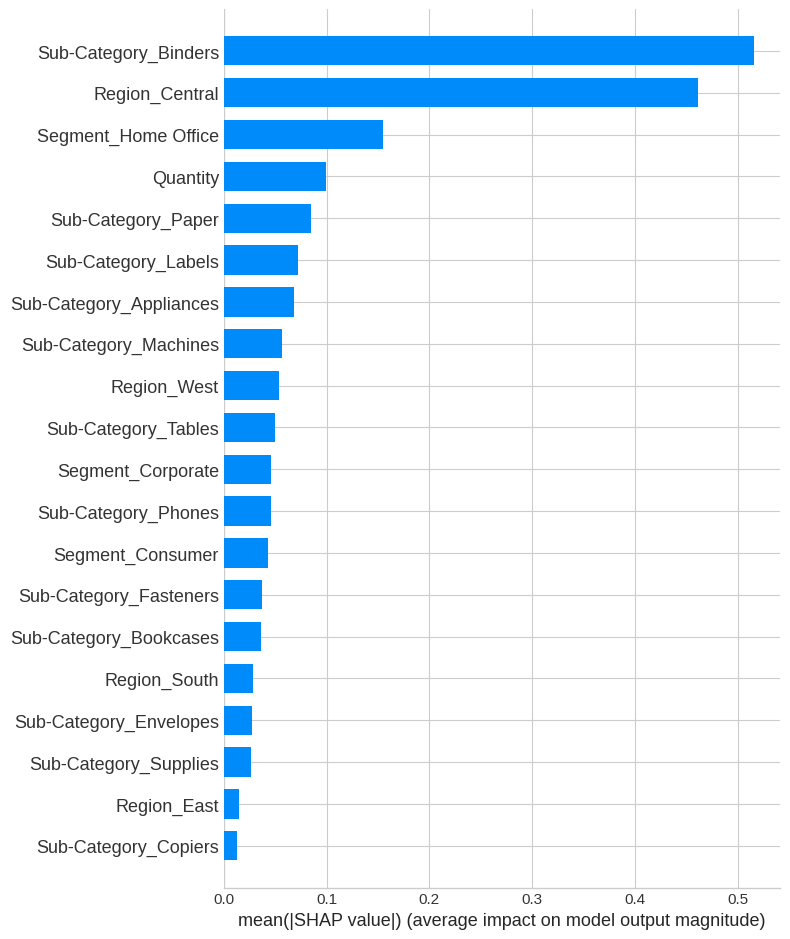

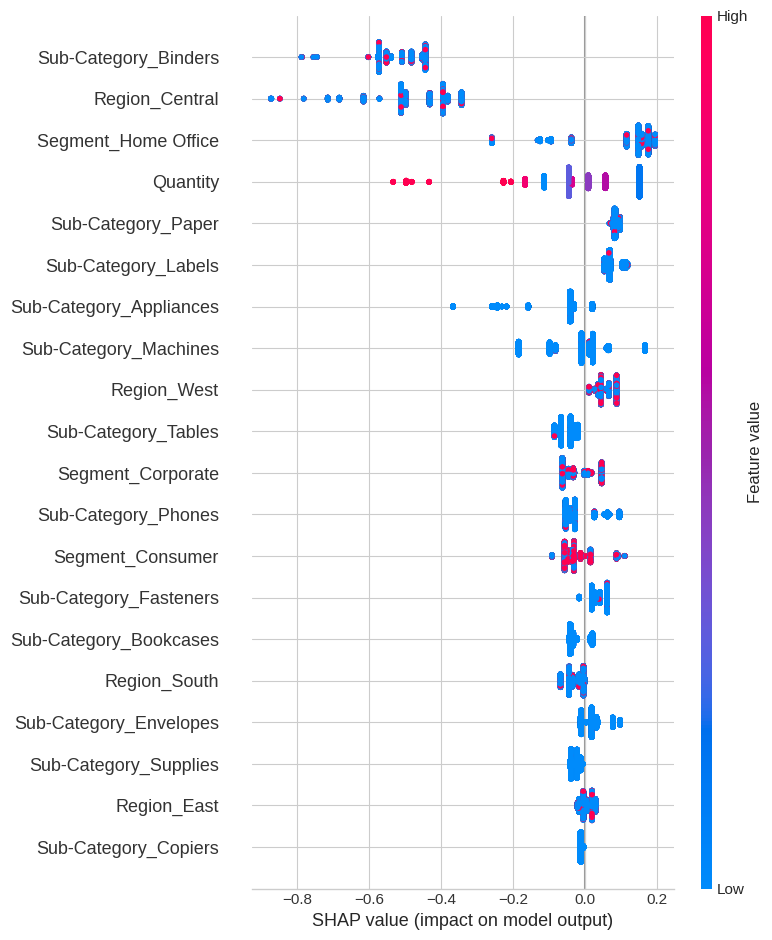


--- Interpretation of the SHAP Summary Plot ---
The beeswarm plot shows the impact of every feature for every data point.
 - Each dot is a transaction.
 - The X-axis is the SHAP value: a positive value pushes the predicted margin HIGHER, a negative value pushes it LOWER.
 - The color indicates the original value of that feature: red for high values, blue for low values.
This plot will reveal the most significant drivers of inherent profitability.
--- SHAP Analysis Complete ---


In [ ]:
!pip install shap

# --- Core Libraries ---
import shap

print("\n--- Starting Phase 3.3: SHAP Analysis for the Strategic Model ---")

try:
    strategic_pipeline = joblib.load('strategic_profit_driver_model.joblib')
    print("Strategic pipeline loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'strategic_profit_driver_model.joblib' not found. Please ensure the previous cell was run successfully.")
    exit()

# SHAP needs the data in its final, pre-processed (numerical) form.
# We will extract the preprocessor and the model from our pipeline.
preprocessor = strategic_pipeline.named_steps['columntransformer']
model = strategic_pipeline.named_steps['xgbregressor']

# We need the feature names after one-hot encoding for the plot.
# The preprocessor can give us these names.
categorical_features = strat_categorical_features # from previous cell
numerical_features = strat_numerical_features # from previous cell
new_categorical_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names = numerical_features + new_categorical_names

# Transform our strategic feature set 'X_strat'
X_strat_transformed = preprocessor.transform(X_strat)
# Convert to a DataFrame for SHAP, using the correct feature names.
X_strat_transformed_df = pd.DataFrame(X_strat_transformed.toarray(), columns=feature_names)


# We use the TreeExplainer, which is optimized for tree-based models like XGBoost.
print("\nCalculating SHAP values... (This may take a moment)")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_strat_transformed_df)
print("SHAP values calculated.")


print("\nGenerating SHAP Summary Plot...")
# The summary plot is the most powerful way to visualize global feature importance.
shap.summary_plot(shap_values, X_strat_transformed_df, plot_type="bar")
shap.summary_plot(shap_values, X_strat_transformed_df)

print("\n--- Interpretation of the SHAP Summary Plot ---")
print("The beeswarm plot shows the impact of every feature for every data point.")
print(" - Each dot is a transaction.")
print(" - The X-axis is the SHAP value: a positive value pushes the predicted margin HIGHER, a negative value pushes it LOWER.")
print(" - The color indicates the original value of that feature: red for high values, blue for low values.")
print("This plot will reveal the most significant drivers of inherent profitability.")
print("--- SHAP Analysis Complete ---")